In [29]:
import math
import torch
from torch.utils.data import Dataset
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA available?:", torch.cuda.is_available())
print("Number of GPUs available:", torch.cuda.device_count())
print("Current GPU:", torch.cuda.current_device())
print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

Is CUDA available?: True
Number of GPUs available: 1
Current GPU: 0
GPU Name: NVIDIA GeForce GTX 1660 SUPER


In [31]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [32]:
class PollutantDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.to(device)
        self.y = y.to(device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [33]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

train_dataset = PollutantDataset(train_x, train_y)

In [34]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_dataset.X, train_dataset.y, likelihood)

model = model.to(device)
likelihood = likelihood.to(device)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
mll = mll.to(device)

n_epochs = 100

for epoch in range(n_epochs):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_dataset.X)
    # Calc loss and backprop gradients
    loss = -mll(output, train_dataset.y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        epoch + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.961   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 0.931   lengthscale: 0.644   noise: 0.644
Iter 3/100 - Loss: 0.898   lengthscale: 0.598   noise: 0.598
Iter 4/100 - Loss: 0.861   lengthscale: 0.555   noise: 0.554
Iter 5/100 - Loss: 0.818   lengthscale: 0.514   noise: 0.513
Iter 6/100 - Loss: 0.770   lengthscale: 0.476   noise: 0.474
Iter 7/100 - Loss: 0.717   lengthscale: 0.440   noise: 0.437
Iter 8/100 - Loss: 0.663   lengthscale: 0.405   noise: 0.402
Iter 9/100 - Loss: 0.612   lengthscale: 0.373   noise: 0.369
Iter 10/100 - Loss: 0.565   lengthscale: 0.343   noise: 0.339
Iter 11/100 - Loss: 0.523   lengthscale: 0.315   noise: 0.310
Iter 12/100 - Loss: 0.486   lengthscale: 0.292   noise: 0.284
Iter 13/100 - Loss: 0.451   lengthscale: 0.271   noise: 0.259
Iter 14/100 - Loss: 0.418   lengthscale: 0.255   noise: 0.236
Iter 15/100 - Loss: 0.386   lengthscale: 0.241   noise: 0.215
Iter 16/100 - Loss: 0.355   lengthscale: 0.230   noise: 0.196
Iter 17/100 - Los

In [35]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    test_x = test_x.to(device)
    observed_pred = likelihood(model(test_x))

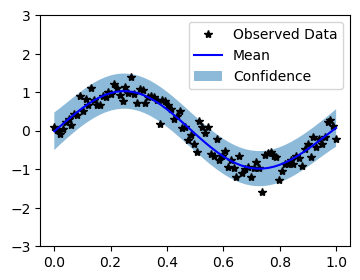

In [36]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])